## Data Loader

### for future: Multistep (60 step) predictions

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

### Creating Custom Dataset

In [20]:
from torch.utils.data import Dataset

#### Final pre-process (creating dummy variables)

In [22]:
# TODO implement random selection

class ProjectDataset(Dataset):
    def __init__(self, data_dir, train_split=1.0, is_test=False, is_validation=False,  transform=None, target_transform=None):
        self.data_dir = data_dir
        self.data = pd.read_csv(data_dir)
        self.transform = transform
        self.target_transform = target_transform
        self.train_split = train_split
        self.is_test = is_test
        self.is_validation = is_validation

        # make categorical
        for column in self.data.columns:
            self.data[column] = self.data[column].astype('category')
            
        if self.is_test == False:
            # slice data to non-test set
            self.data = self.data.iloc[0:1558116]
            # randomize and slice data appropriately
            np.random.seed(11020)
            self.data = self.data.iloc[np.random.permutation(self.data.index)].reset_index(drop=True)
            slice_ix = int(len(self.data) * train_split //1)
            if self.is_validation == True:
                self.data = self.data[slice_ix:]
            else:
                self.data = self.data[:slice_ix]

        else:
            # test set, no need to sample
            self.data = self.data.iloc[1558116:1558116+320]

        self.features = self.data.iloc[:,:6]
        self.labels = self.data.iloc[:,6]

        # convert features to dummy variables
        for i in range(0,3):
            #if i == 2:  # need to rework features, this bypasses taxi_id entirely
            #   continue
            dummies = pd.get_dummies(self.features.iloc[:,i])
            self.features = pd.concat([self.features, dummies], axis=1)
        self.features = self.features.drop(['CALL_TYPE', 'ORIGIN', 'TAXI_ID', 'MON', 'HR', 'WK'], axis=1)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature = torch.Tensor((np.array(self.features.iloc(axis=0)[idx])))
        label = torch.tensor(self.labels.iloc[idx]).float()
        if self.is_test == True:
            label = torch.tensor(0).float()
        if self.transform:
            feature = self.transform(feature)
        if self.target_transform:
            label = self.target_transform(label)
            
        return feature, label

### Creating custom DataLoader

In [23]:
batch_size = 2**14

trainset = ProjectDataset(data_dir='./data/all_data.csv', train_split=1) # consider custom normalize approach for data
validset = ProjectDataset(data_dir='./data/all_data.csv', train_split=0.8, is_validation=True)

train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True)
valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True)

## Define Our Neural Network

In [24]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1080 Ti'

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class ProjectNet(nn.Module):
    def __init__(self, dropout_p, feat_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        out = self.model(x)
        
        return out

## Training the Network

In [26]:
import torch.optim as optim
import time

In [27]:
def run_epoch(epoch_count, net, validate=False):
    criterion = nn.L1Loss()
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    prev_valid_loss = 1e10   # arbitrarily high value so first iteration completes
    losses = pd.DataFrame(columns=['Epoch', 'Train loss', 'Valid loss'])    # data frame to carry train/validation statistics
    for epoch in range(epoch_count):  # loop over the dataset multiple times
        time_start = time.perf_counter()
        for i in range(40):
            print('-',end="")
        print()
        print("Epoch: ", epoch+1, "/", epoch_count)
        for i in range(40):
            print('-',end="")
        print()
        
        running_loss = 0.0
        # Training epoch cycle and loss
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            ppe = 5     # ppe: print per epoch, number of time to print data per epoch of training
            iter_count = int(len(trainset)/batch_size/ppe)
            if i % iter_count == iter_count - ppe:    # print exactly `ppe` times per epoch of training
                train_loss = running_loss / iter_count
                df_entry = pd.DataFrame({'Epoch': epoch, 'Train loss': train_loss, 'Valid loss': None,
                                         'Elapsed time': (time.perf_counter() - time_start)}, index=[1])
                losses = pd.concat([losses, df_entry], axis=0, ignore_index=True)
                print(f'[{epoch + 1}, {i + 1:5d}] Training loss: {train_loss:.3f}')
                running_loss = 0.0
        
        # Validation cycle and loss calculation
        if validate == True:
            running_valid_loss = []
            for i, val_data in enumerate(valid_dataloader, 0):
                inputs, labels = val_data[0].to(device), val_data[1].to(device)
                with torch.no_grad():
                    outputs = net(inputs)
                    valid_loss = criterion(outputs.squeeze(), labels.squeeze())
                    running_valid_loss.append(valid_loss.item())
            valid_loss = sum(running_valid_loss) / len(running_valid_loss)
            losses.iat[-1, losses.columns.get_loc('Valid loss')] = valid_loss
            print(f'\n[{epoch + 1}] Validation loss:  {valid_loss:.3f}')
            if (valid_loss > prev_valid_loss):
                print(f"\nEarly Stopping!\nEpoch over epoch validation loss increased :  {valid_loss:.3f} > {prev_valid_loss:.3f}")
                break
            prev_valid_loss = valid_loss
            
        
    print('Finished Training')
    return losses

In [123]:
df.to_pickle('drop_out 0.3 3 epochs.pkl')

In [28]:
dropout_perc = [0.3]
df = pd.DataFrame(columns=['Epoch', 'Train loss', 'Valid loss', 'Dropout %'])
for i in range(len(dropout_perc)):
    net=ProjectNet(dropout_perc[i], trainset[0][0].shape[0]).to(device)  # check modules and send to CUDA
    print(f"Total parameter count: {sum(p.numel()for p in net.parameters())}")
    df_add = run_epoch(epoch_count=3, net=net, validate=True)
    df_add.loc[:, 'Dropout %'] = dropout_perc[i]
    df = pd.concat([df, df_add], axis=0, ignore_index=True)

Total parameter count: 3390119
----------------------------------------
Epoch:  1 / 3
----------------------------------------
[1,    15] Training loss: 563.278
[1,    34] Training loss: 460.158
[1,    53] Training loss: 328.166
[1,    72] Training loss: 309.889
[1,    91] Training loss: 306.065

[1] Validation loss:  303.537
----------------------------------------
Epoch:  2 / 3
----------------------------------------
[2,    15] Training loss: 238.523
[2,    34] Training loss: 299.290
[2,    53] Training loss: 296.968
[2,    72] Training loss: 296.963
[2,    91] Training loss: 296.987

[2] Validation loss:  295.488
----------------------------------------
Epoch:  3 / 3
----------------------------------------
[3,    15] Training loss: 233.919
[3,    34] Training loss: 295.509
[3,    53] Training loss: 295.990
[3,    72] Training loss: 295.323
[3,    91] Training loss: 294.794

[3] Validation loss:  295.705

Early Stopping!
Epoch over epoch validation loss increased :  295.705 > 295.4

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
df = pd.read_pickle('dropout_test.pkl')

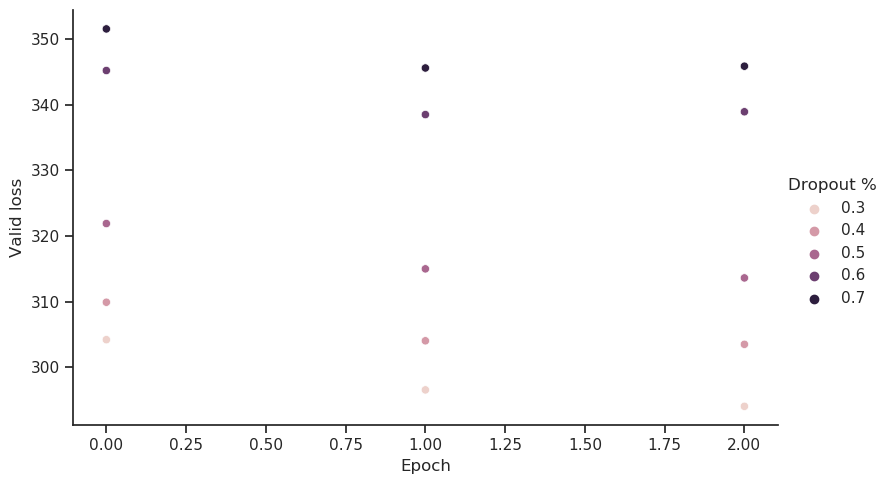

In [119]:
df_plt = df.dropna()
sns.set(style='ticks')
_dropouts = [0.3, 0.4, 0.5, 0.6, 0.7]
ax = sns.relplot(data=df_plt, x='Epoch', y='Valid loss', hue='Dropout %', hue_order=_dropouts, aspect=1.61, kind='scatter')
#ax.fig.axes[0].invert_yaxis()
plt.show(ax)

### Saving our model

In [30]:
PATH = './model/proj_model_4.pth' # next save

In [31]:
torch.save(net.state_dict(), PATH)

### Loading our model

In [10]:
PATH = './model/proj_model_2.pth' # previous save

In [14]:
dropout_perc = 0    # !! DISABLE drop out for testing
net2 = ProjectNet(dropout_perc, trainset[0][0].shape[0]).to(device)

In [15]:
net2.load_state_dict(torch.load(PATH))
net2.to(device)

ProjectNet(
  (model): Sequential(
    (0): Linear(in_features=1110, out_features=1110, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=1110, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0, inplace=False)
    (9): Linear(in_features=512, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0, inplace=False)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): ReLU()
    (14): Dropout(p=0, inplace=False)
    (15): Linear(in_features=128, out_features=32, bias=True)
    (16): ReLU()
    (17): Dropout(p=0, inplace=False)
    (18): Linear(in_features=32, out_features=1, bias=True)
  )
)

## Testing our Model

In [16]:
batch_size = 320

testset = ProjectDataset(data_dir='./data/all_data.csv', train_split=(1), is_test=True) # consider custom normalize approach for data

test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                shuffle=False, num_workers=1)

In [17]:
with torch.no_grad():
    for data in test_dataloader:
        features = data[0].to(device)
        outputs = net2(features)

outputs = outputs.detach().cpu().numpy()
outputs = (outputs / 15).round() * 15
out_data = outputs

In [18]:
# final rounding
out_data = np.array(out_data)
to_export = pd.read_csv('./data/test_public.csv')
to_export['TRAVEL_TIME'] = pd.DataFrame(out_data)
to_export = to_export.loc[:,['TRIP_ID', 'TRAVEL_TIME']]
to_export.to_csv('./data/predictions.csv', index=False)